# Land - Near Surface Air Temperature Quantile Notebook
This notebook looks at how the high quantiles for near surface air temperature vary with longwave optical depth ($CO_2$ concentration proxy) over ocean and land.

It is analagous to `quantile_notebook2.ipynb` for the [aquaplanet simulations](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/aquaplanet/quantile_notebook2.ipynb) i.e. it uses near surface air temperature (temperature at lowest pressure level recorded) rather than surface temperature.


In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-01-16 10:20:25,470 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset
exp_dir = 'tau_sweep/land/meridional_band/evap/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

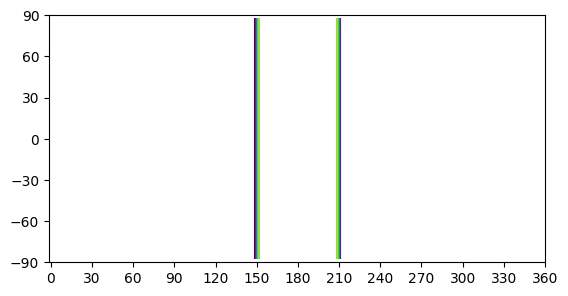

In [5]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

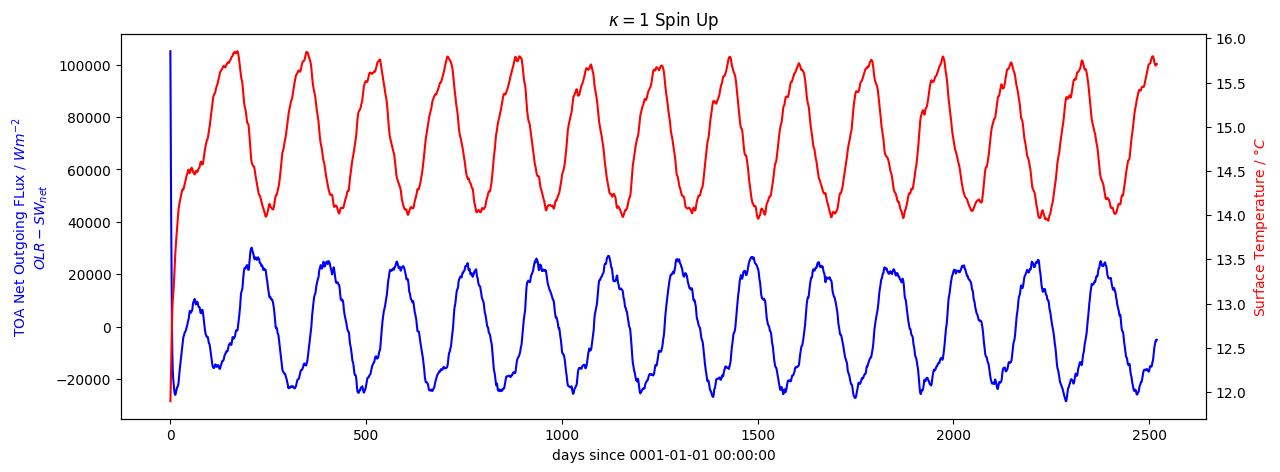

In [10]:
# Plot spin up time
tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds[tau_ref_ind].olr, frierson_net_toa_sw_dwn(ds[tau_ref_ind].swdn_toa, ds[tau_ref_ind].ps,
                                                                          albedo[tau_ref_ind], tau_sw[tau_ref_ind]),
                             ds[tau_ref_ind].t_surf, ax)
plt.title('$\kappa = 1$ Spin Up');

In [11]:
## Split datasets into land and ocean ones
ds_land = []
ds_ocean = []
land_lon = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
ocean_lon = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
for i in range(n_exp):
    ds_land += [ds[i].sel(lon=np.unique(land_lon), method='nearest')]
    ds_ocean += [ds[i].sel(lon=np.unique(ocean_lon), method='nearest')]

## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [15]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
temp_av = np.zeros(n_exp) # average global temperature across land and ocean
ds_temp = {'land': [], 'ocean': []}    # near surface temperature for each optical depth value
for i in range(n_exp):
    # only keep air temperature nearest surface and in converged time period
    ds_temp['land'] += [ds_land[i].sel(time=slice(use_time_start, np.inf)).temp.sel(pfull=np.inf, method='nearest')]
    ds_temp['ocean'] += [ds_ocean[i].sel(time=slice(use_time_start, np.inf)).temp.sel(pfull=np.inf, method='nearest')]
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf)).temp.sel(pfull=np.inf, method='nearest')
    temp_av[i] = area_weighting(ds_use).mean(dim=['lon', 'lat', 'time']).to_numpy()

In [18]:
# Compute quantile near surface temperature across longitude and time dimension for each latitude
quantiles = [90, 99, 99.9, 99.99]
n_quantiles = len(quantiles)
latitudes = ds_temp['ocean'][0].lat.to_numpy()
n_latitude = len(latitudes)
weights = np.cos(np.deg2rad(latitudes))
temp_quant = {'land': np.zeros((n_exp, n_quantiles, n_latitude)), 'ocean': np.zeros((n_exp, n_quantiles, n_latitude))}
for i in range(n_exp):
    # Collapse longitude and time dimensions because they are all equivalent in an aquaplanet (expect for the seasonality).
    for surf in ['land', 'ocean']:
        data_use = ds_temp[surf][i].stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        for j in range(n_quantiles):
                temp_quant[surf][i, j, :] = data_use.quantile(quantiles[j]/100, dim='lon_time').to_numpy()


In [19]:
# Only consider a given latitude range
region = 'Extratropics'      # Tropics or Extratropics
if region.lower() == 'tropics':
    lat_min = 0
    lat_max = 20
elif region.lower() == 'extratropics':
    lat_min = 30
    lat_max = 60
else:
    raise ValueError('Not valid region')
lat_use = np.where(np.logical_and(np.abs(latitudes)<lat_max, np.abs(latitudes)>=lat_min))[0]

# Don't think it is appropriate to use weights because the percentiles at different locations correspond to different days
# Weighting makes sense for global average temperature but not for this I don't think
temp_quant_use = {}
for surf in ['land', 'ocean']:
    temp_quant_use[surf] = np.average(temp_quant[surf][:, :, lat_use], axis=2)
# temp_quant_use = np.average(temp_quant[:, :, lat_use], axis=2, weights = weights[lat_use])

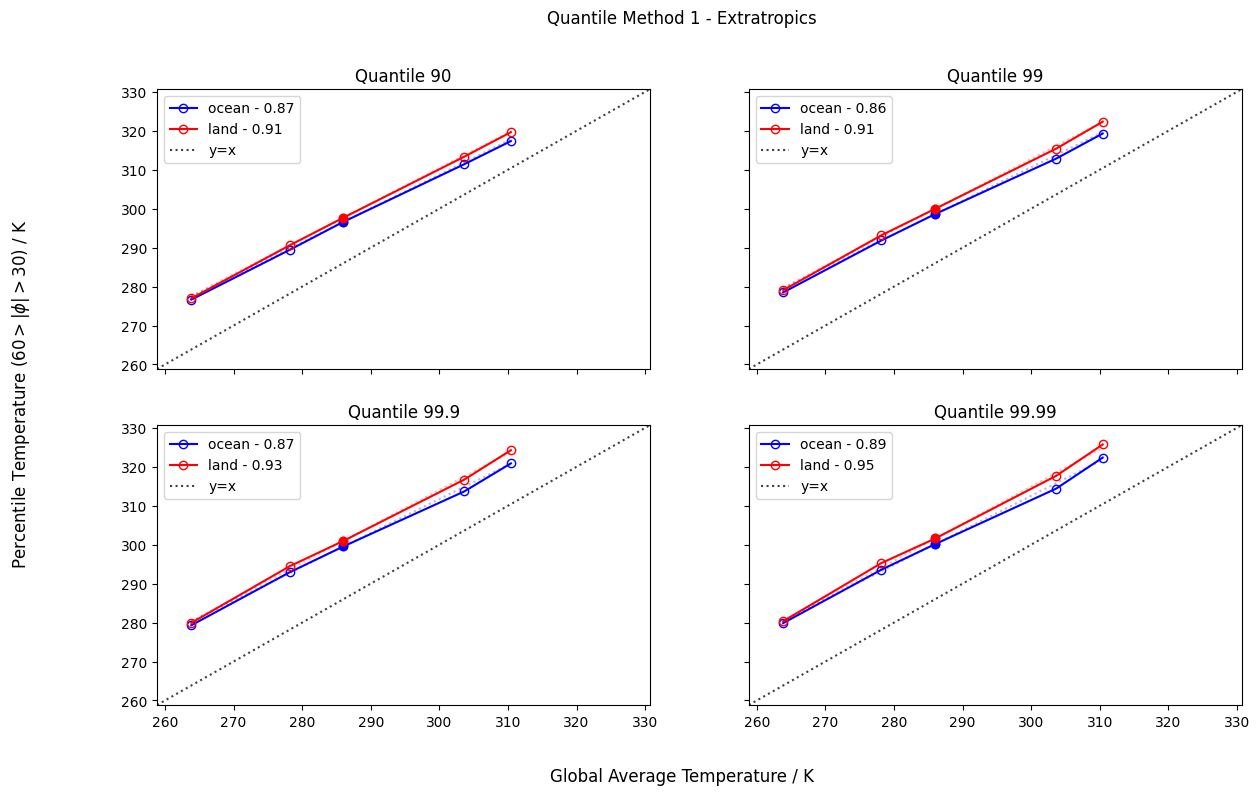

In [33]:
fig, ax = plt.subplots(int(np.ceil(n_quantiles/2)),2, figsize=(14, 8), sharex=True, sharey=True)
ax = ax.flatten()
temp_min = temp_av.min() - 5
temp_max = temp_quant_use['land'].max() + 5
plt_color = {'land': 'red', 'ocean': 'blue'}
for j in range(n_quantiles):
    for surf in ['ocean', 'land']:
        # Straight line through the ref point
        fit_func = lambda x, m: temp_quant_use[surf][tau_ref_ind, j] + m*(x-temp_av[tau_ref_ind])
        param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant_use[surf][:, j])[0]
        ax[j].plot(temp_av, temp_quant_use[surf][:, j], marker='o', label='{} - {:.2f}'.format(surf, param[0]),
                color=plt_color[surf], fillstyle='none')
        # Filled circle for reference simulation
        ax[j].plot(temp_av[tau_ref_ind], temp_quant_use[surf][tau_ref_ind, j], marker='o', color=plt_color[surf], fillstyle='full')
        ax[j].plot(temp_av, fit_func(temp_av, param), linestyle=':', color=plt_color[surf], alpha=0.3)
    # # now plot y=x so can see how the rate compares to the increase of the mean
    ax[j].set_xlim([temp_min, temp_max])
    ax[j].set_ylim([temp_min, temp_max])
    ax[j].plot([ax[j].get_xlim()[0], ax[j].get_ylim()[1]], [ax[j].get_xlim()[0], ax[j].get_ylim()[1]],
               'k:', alpha=0.75, zorder=0,label='y=x')
    ax[j].legend()
    ax[j].set_title(f'Quantile {quantiles[j]}')
fig.suptitle(f'Quantile Method 1 - {region}')
fig.supxlabel('Global Average Temperature / K')
fig.supylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K');

The linear increase above and below is just a straight line fit that goes through the reference point, for which the optical depth parameter is 1.

The plot below shows the quantiles computed across all latitudes, longitudes and time in the given latitude range. There doesn't really seem to be much difference between the two methods of computing the quantiles.

In [34]:
# Compute quantile across all selected latitudes rather than for each latitude.
temp_quant_use2 = {'land': np.zeros((n_exp, n_quantiles)), 'ocean': np.zeros((n_exp, n_quantiles))}
temp_local_mean = {'land': np.zeros(n_exp), 'ocean': np.zeros(n_exp)}     # record mean temperature in the given latitude range
temp_local_summer_mean = {'land': np.zeros(n_exp), 'ocean': np.zeros(n_exp)}    # record mean summer temperature in given latitude range
for i in range(n_exp):
    for surf in ['land', 'ocean']:
        # Collapse longitude and time dimensions because they are all equivalent in an aquaplanet (expect for the seasonality).
        data_use = ds_temp[surf][i].where((np.abs(ds_temp[surf][i].lat) <= lat_max) & (np.abs(ds_temp[surf][i].lat) >= lat_min), drop=True)
        ds_nh_summer = isca_tools.utils.annual_time_slice(data_use, [6, 7, 8]).sel(lat=slice(0, lat_max))    # NH summer is JJA
        ds_sh_summer = isca_tools.utils.annual_time_slice(data_use, [12, 1, 2]).sel(lat=slice(-lat_max, 0))    # SH summer is DJF
        temp_summer = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat')
        temp_local_summer_mean[surf][i] = temp_summer.mean().to_numpy()
        temp_local_mean[surf][i] = data_use.mean(dim=['lon', 'time', 'lat'])
        # Forget weighted mean for now - not sure if appropriate for this analysis - THIS MAY BE WRONG THOUGH!!!
        # temp_local_summer_mean[i] = area_weighting(temp_summer).mean().to_numpy()
        # temp_local_mean[i] = area_weighting(data_use.t_surf).mean(dim=['lon', 'time', 'lat'])
        data_use = data_use.stack(lon_lat_time=("lon","time", "lat"), create_index=False).chunk(dict(lon_lat_time=-1)).to_numpy()
        temp_quant_use2[surf][i, :] = np.quantile(data_use, np.asarray(quantiles)/100)

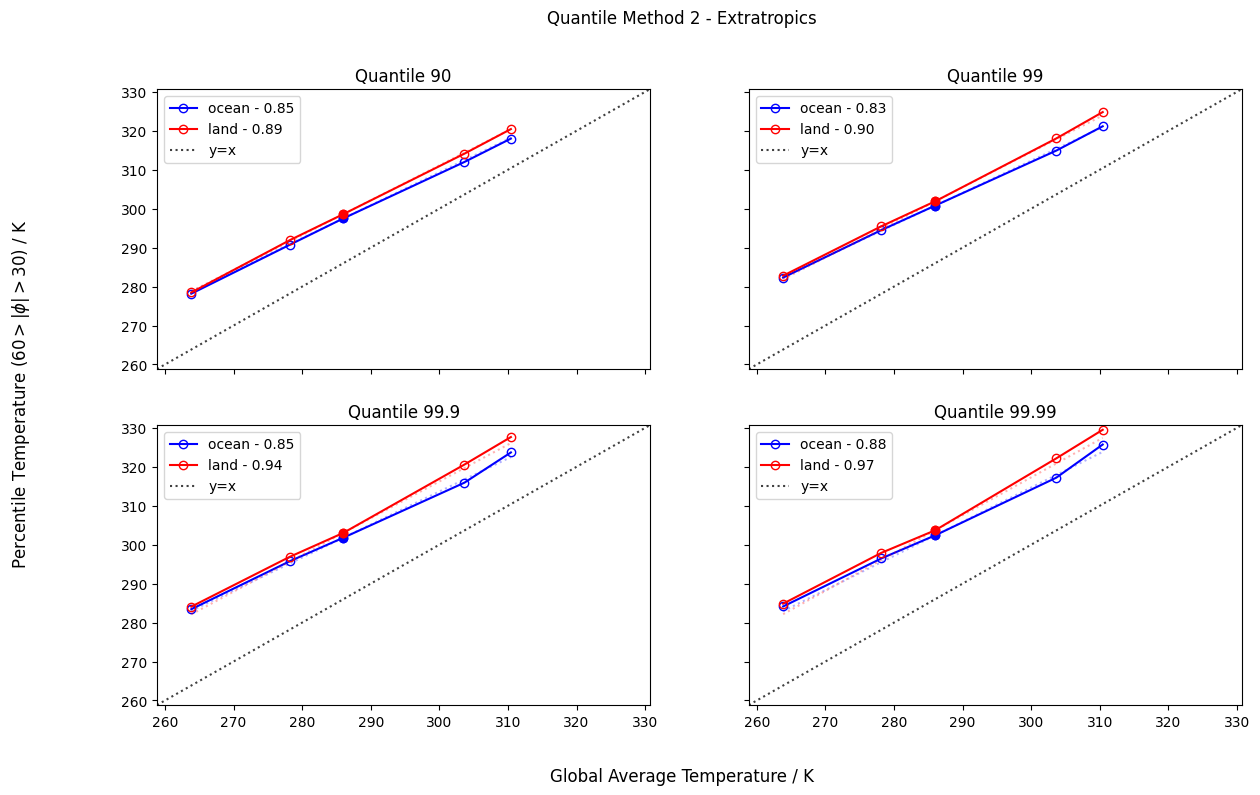

In [35]:
fig, ax = plt.subplots(int(np.ceil(n_quantiles/2)),2, figsize=(14, 8), sharex=True, sharey=True)
ax = ax.flatten()
for j in range(n_quantiles):
    for surf in ['ocean', 'land']:
        # Straight line through the ref point
        fit_func = lambda x, m: temp_quant_use2[surf][tau_ref_ind, j] + m*(x-temp_av[tau_ref_ind])
        param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant_use2[surf][:, j])[0]
        ax[j].plot(temp_av, temp_quant_use2[surf][:, j], marker='o', label='{} - {:.2f}'.format(surf, param[0]),
                color=plt_color[surf], fillstyle='none')
        # Filled circle for reference simulation
        ax[j].plot(temp_av[tau_ref_ind], temp_quant_use2[surf][tau_ref_ind, j], marker='o', color=plt_color[surf], fillstyle='full')
        ax[j].plot(temp_av, fit_func(temp_av, param), linestyle=':', color=plt_color[surf], alpha=0.3)
    # # now plot y=x so can see how the rate compares to the increase of the mean
    ax[j].set_xlim([temp_min, temp_max])
    ax[j].set_ylim([temp_min, temp_max])
    ax[j].plot([ax[j].get_xlim()[0], ax[j].get_ylim()[1]], [ax[j].get_xlim()[0], ax[j].get_ylim()[1]],
               'k:', alpha=0.75, zorder=0,label='y=x')
    ax[j].legend()
    ax[j].set_title(f'Quantile {quantiles[j]}')
fig.suptitle(f'Quantile Method 2 - {region}')
fig.supxlabel('Global Average Temperature / K')
fig.supylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K');

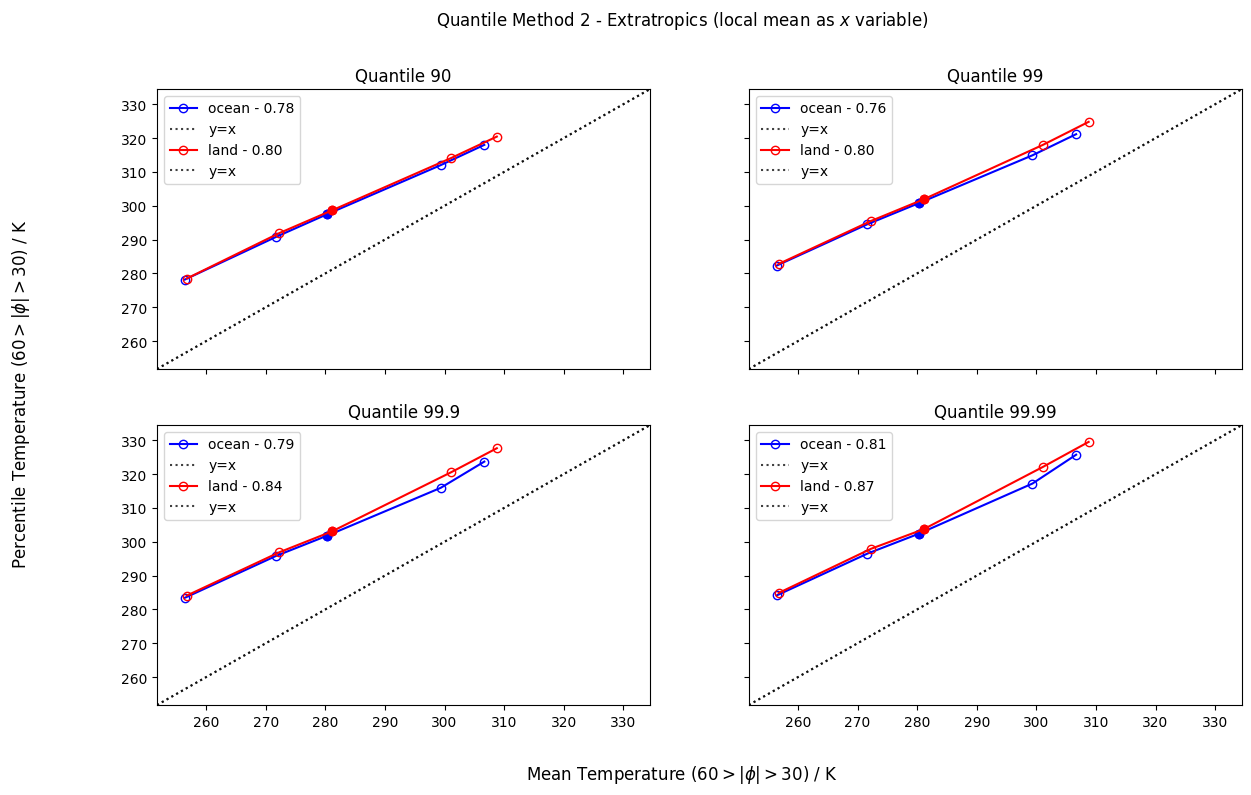

In [43]:
# Plot local quantile temperature vs local mean temperature within the given latitude band
fig, ax = plt.subplots(int(np.ceil(n_quantiles/2)),2, figsize=(14, 8), sharex=True, sharey=True)
ax = ax.flatten()
x_var_use = 'mean'   # Can choose summer mean temperature or overall mean temperature to plot
if x_var_use == 'summer_mean':
    x_var = temp_local_summer_mean
    fig.supxlabel(f'Mean Summer Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
else:
    x_var = temp_local_mean
    fig.supxlabel(f'Mean Temperature (${lat_max}>|\phi| > {lat_min}$) / K')

quantile_method = 2     # Can choose whether to use method 1 or 2 for computing the quantile temperature
if quantile_method == 2:
    y_var = temp_quant_use2
else:
    y_var = temp_quant_use

temp_min_local = x_var['land'].min() - 5
temp_max_local = y_var['land'].max() + 5
for j in range(n_quantiles):
    for surf in ['ocean', 'land']:
        fit_func = lambda x, m: y_var[surf][tau_ref_ind, j] + m*(x-x_var[surf][tau_ref_ind])     # Straight line through the ref point
        param = scipy.optimize.curve_fit(fit_func,x_var[surf], y_var[surf][:, j])[0]
        ax[j].plot(x_var[surf], y_var[surf][:, j], marker='o', label='{} - {:.2f}'.format(surf, param[0]),
                color=plt_color[surf], fillstyle='none')
        # Filled circle for reference simulation
        ax[j].plot(x_var[surf][tau_ref_ind], y_var[surf][tau_ref_ind, j], marker='o',
                color=plt_color[surf], fillstyle='full')
        ax[j].set_xlim([temp_min_local, temp_max_local])
        ax[j].set_ylim([temp_min_local, temp_max_local])
        ax[j].plot([ax[j].get_xlim()[0], ax[j].get_ylim()[1]], [ax[j].get_xlim()[0], ax[j].get_ylim()[1]],
                   'k:', alpha=0.75, zorder=0,label='y=x')
        ax[j].legend()
        ax[j].set_title(f'Quantile {quantiles[j]}')
fig.suptitle(f'Quantile Method 2 - {region} (local {x_var_use} as $x$ variable)')
fig.supylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K');
# plt.savefig('/Users/joshduffield/Desktop/hello2.png', bbox_inches='tight', dpi=400)

## Attempt to replicate Figure 2 of Byrne 2021
I.e. want to plot change between $\kappa = 2$ and $\kappa = 1$ simulations for each quantile of temperature. Then compare this to the change in the mean temperature, through the scaling factor.


In [45]:
# Get change for each quantile between a warmed world and a reference world
ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
tau_lw_warm = 3.5       # Different from aquaplanet where used tau_lw_warm=2 but did not run this simulation with land.
warm_ind = np.where(np.asarray(tau_lw)==tau_lw_warm)[0][0]
quantiles_all = np.arange(100)
temp_all_quant = {'land': np.zeros((2, len(quantiles_all))), 'ocean': np.zeros((2, len(quantiles_all)))}
for i in range(2):
    for surf in ['land', 'ocean']:
        if i == 0:
            data_use = ds_temp[surf][ref_ind]
        else:
            data_use = ds_temp[surf][warm_ind]
        data_use = data_use.where((np.abs(data_use.lat) <= lat_max) & (np.abs(data_use.lat) >= lat_min), drop=True)
        data_use = data_use.stack(lon_lat_time=("lon", "time", "lat"), create_index=False).chunk(dict(lon_lat_time=-1)).to_numpy()
        quant_thresh = np.quantile(data_use, quantiles_all/100)
        for j in tqdm(quantiles_all):
            # Average temperature over days exceeding the percentile
            temp_all_quant[surf][i, j] = data_use[data_use>quant_thresh[j]].mean()

100%|██████████| 100/100 [00:00<00:00, 164.15it/s]


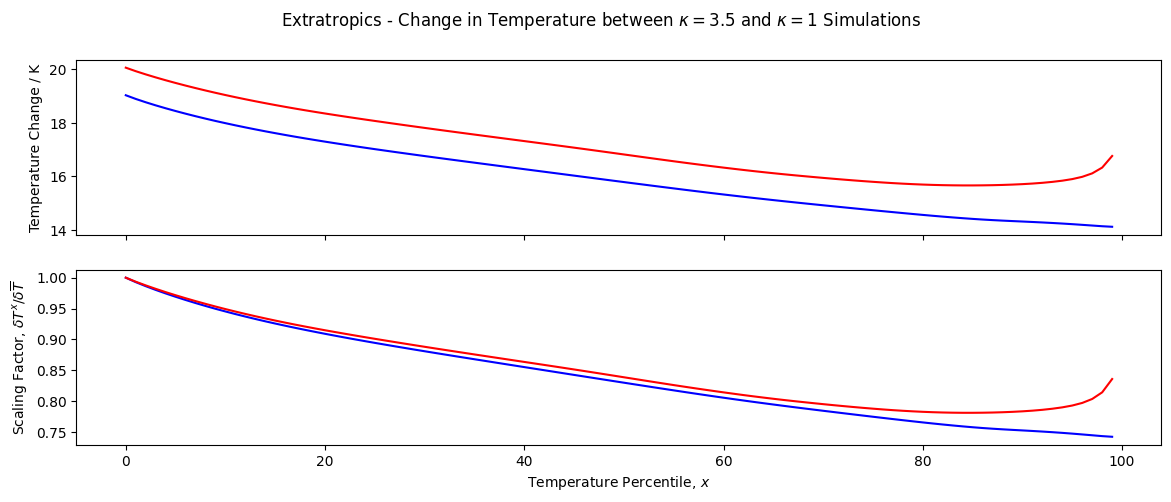

In [47]:
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
for surf in ['ocean', 'land']:
    ax[0].plot(quantiles_all, temp_all_quant[surf][1]-temp_all_quant[surf][0], color=plt_color[surf], label=surf)
    ax[1].plot(quantiles_all,
               (temp_all_quant[surf][1]-temp_all_quant[surf][0])/(temp_local_mean[surf][warm_ind] - temp_local_mean[surf][ref_ind]),
               color=plt_color[surf], label=surf)
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Variation with latitude
The plot below is inspired by Figure 2 in *O'Gorman Schneider 2009*, showing the change in the 99.9 percentile and mean temperature with respect to a reference experiment, as a function of latitude.


In [48]:
# Get change in a given percentile of temperature between a warmer simulation and a reference
quant_plot = 99.9
temp_quant_ref = {}
temp_quant_warm = {}
temp_quant_diff = {}
global_temp_diff = float(temp_av[np.asarray(tau_lw)==tau_lw_warm] - temp_av[np.asarray(tau_lw)==tau_lw_ref])
for surf in ['land', 'ocean']:
    temp_quant_ref[surf] = temp_quant[surf][np.asarray(tau_lw)==tau_lw_ref, np.asarray(quantiles)==quant_plot, :].flatten()
    temp_quant_warm[surf] = temp_quant[surf][np.asarray(tau_lw)==tau_lw_warm, np.asarray(quantiles)==quant_plot, :].flatten()
    temp_quant_diff[surf] = (temp_quant_warm[surf]-temp_quant_ref[surf])

In [51]:
# Get change in mean temperature
mean_temp_ref = {}
mean_temp_warm = {}
mean_temp_diff = {}
for surf in ['land', 'ocean']:
    mean_temp_ref[surf] = ds_temp[surf][np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]].mean(dim=["lon","time"])
    mean_temp_warm[surf] = ds_temp[surf][np.where(np.asarray(tau_lw)==tau_lw_warm)[0][0]].mean(dim=["lon","time"])
    mean_temp_diff[surf] = (mean_temp_warm[surf]-mean_temp_ref[surf])

Results are normalised by Global Mean Surface Temperature Difference of 17.64 K


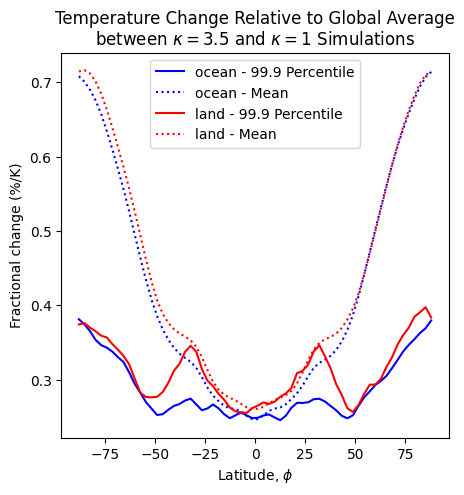

In [52]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
for surf in ['ocean', 'land']:
    ax.plot(latitudes, temp_quant_diff[surf] / global_temp_diff / temp_quant_ref[surf] * 100,
            label=f"{surf} - {quant_plot} Percentile", color = plt_color[surf])
    ax.plot(latitudes, mean_temp_diff[surf] / global_temp_diff / mean_temp_ref[surf] * 100,
            label=f"{surf} - Mean", linestyle=':', color = plt_color[surf])
ax.set_ylabel('Fractional change (%/K)')
ax.set_xlabel('Latitude, $\phi$')
ax.legend()
ax.set_title(f'Temperature Change Relative to Global Average\nbetween $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations')
print("Results are normalised by Global Mean Surface Temperature Difference of {:.2f} K".format(global_temp_diff))